# MesaNet

MesaNet is a novel architecture for sequence modeling that aims to overcome the linear scaling memory and compute requirements of traditional causal transformer architectures during inference. It introduces a Mesa layer, which is a numerically stable, chunkwise parallelizable recurrent neural network (RNN) layer.

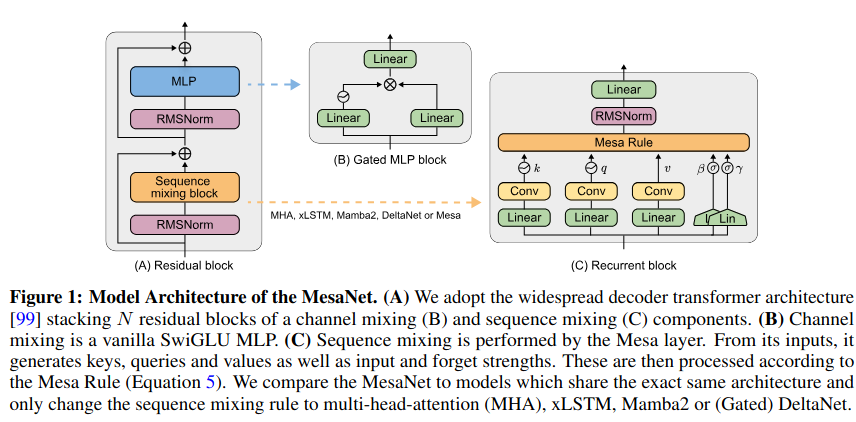

The key features of MesaNet:

**Optimal Test-Time Training**:

Unlike other RNNs that approximate an in-context regression objective through online learning rules (like gradient descent), the Mesa layer minimizes an in-context loss function to optimality at every time point. This allows it to retain past information and adapt to new evidence quickly as a sequence unfolds.

It defines the linear map (Φ<sub>t</sub>) as the solution to a cumulative regularized squared-error loss, taking into account all data seen so far (e1:t).

This optimization problem is solved using a fast Conjugate Gradient (CG) solver for a linear system of equations (linsolve(H<sub>h,t</sub> + Λ<sub>h</sub>, q<sub>h,t</sub>)), where H<sub>h,t</sub> is a state variable maintained through a linear recurrence, representing an accumulation of past key-key outer products; Λ<sub>h</sub> - regularization parameter, q<sub>h,t</sub> - query vector for head h at time t. E.g. at each step a linear system of equations is solved to find optimal q<sub>t</sub><sup>*</sup>

**Recurrent Neural Network (RNN) with Constant Complexity**:

MesaNet is part of a stream of work on RNN models that achieve constant memory and compute costs during inference, a significant advantage over Transformers, especially for autoregressive tasks like language modeling.

It processes sequences by representing and learning a linear model in its activations, similar to "fast weight programming layers".

**Chunkwise Parallelizable Design**:

The Mesa layer is designed to be parallelizable over sequence length, allowing for efficient training by leveraging matrix multiplication accelerators like GPUs and TPUs. This is achieved by exploiting an equivalence of the CG method over multiple time steps with gated linear self-attention.

**Dynamic Test-Time Compute Allocation**:

A significant feature is its ability to dynamically adapt its computational cost at test time based on the sequence being processed.

The number of CG steps required to reach a desired error tolerance (ϵ) is generally head-, sequence-, and token-specific, allowing the Mesa layer to exhibit dynamic inference costs. This means it can trade off test-time compute for performance. For example, using a dynamic stopping criterion of ϵ = 10^-4 can achieve performance on par with a fixed 30 CG steps, while reducing the average CG steps to approximately 9.

**Mesa Rule**:
    
The Mesa layer output (∆emesa t) is computed by summing over multiple heads, each involving a linsolve operation: 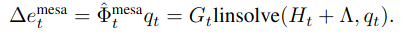

It maintains two crucial state variables, G<sub>h,t</sub> and <sub>h,t</sub>, which are updated using linear recurrence relations involving forget gates (γh,t) and input gates (βh,t):

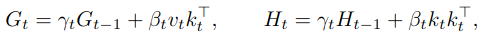

v<sub>t</sub> - values vector at time t, k<sub>t</sub> - key vector at time t

Input and forget gates (β<sub>t</sub>, γ<sub>t</sub>) are functions of the current input and are bounded within to improve performance. The forget gate γ<sub>t</sub> is upper-bounded (e.g., 0.9975) and adjusted based on input strength for numerical stability.

Regularization parameters (Λ<sub>h</sub>) are applied to the linear system and are passed through a softplus function to ensure positivity. These parameters are generally fixed over time and lower-bounded (e.g., 0.25) to control the condition number.

Input embeddings undergo RMS Normalization. Keys (k<sub>t</sub>), queries (q<sub>t</sub>), and values (v<sub>t</sub>) are generated via linear projections, convolved in time, and then keys and queries are L2-normalized after a SiLU non-linearity.

**Performance on Benchmarks**:

Synthetic Tasks: MesaNet excels at synthetic tasks like RegBench and MAD, outperforming other linear transformer alternatives and performing on par with Transformers on RegBench.

Language Modeling: MesaNet and its hybrid variant, Hawk-MesaNet, achieve lower validation perplexity on the SlimPajama dataset compared to other RNN models like Mamba2, xLSTM, and DeltaNet, and can match or even surpass Transformer baselines in average per-token perplexity.

Context Understanding: It shows strong performance early in sequences and extends its advantage in language modeling beyond 512 tokens compared to other recurrent models. On global downstream benchmarks requiring longer contexts, MesaNet outperforms other recurrent models, though it might still underperform the transformer baseline.

In-Context Recall: MesaNet generally outperforms other recurrent models and even exceeds SWA-1024, but a gap remains with Transformer baselines.

Few-Shot Learning: It demonstrates strong performance on word scrambling tasks, often outperforming the Transformer, but typically fails to match Transformer performance on translation tasks.